<a href="https://colab.research.google.com/github/sh3986/kaggle/blob/main/project4/RL_Challenge_FlappyBird_back_gray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Learning Challenge : FlappyBird

In [49]:
!pip install pygame munch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Google Drive 연동
구글 드라이브에 본 프로젝트 폴더를 저장한 후, 구글드라이브를 마운트


In [50]:
from google.colab import drive
drive.mount('/content/gdrive')

import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks/Kaggle/project_4_RL/RL_Challenge')  # 본 프로젝트 폴더 주소를 입력

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [51]:
%cd /content/gdrive/MyDrive/Colab Notebooks/Kaggle/project_4_RL/RL_Challenge

/content/gdrive/MyDrive/Colab Notebooks/Kaggle/project_4_RL/RL_Challenge


###*DQN* class 정의

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DQN(nn.Module):
    def __init__(self, channel_in=1):
        super(DQN, self).__init__()
        self.number_of_actions = 2

        # 1, 1, 84, 84
        self.conv1 = nn.Conv2d(channel_in, 32, kernel_size = 8, stride = 4)
        # 1, 32, 20, 20
        self.conv2 = nn.Conv2d(32, 64, 4, 2)
        # 1, 64, 9, 9
        self.conv3 = nn.Conv2d(64, 64, 3, 1)
        # 1, 64, 7, 7
        self.fc4 = nn.Linear(7 * 7 * 64, 512)
        self.fc5 = nn.Linear(512, self.number_of_actions)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x.view(x.size(0), -1)))
        return self.fc5(x)


### Training

In [53]:
import os
import sys
import time
import random
import argparse
from glob import glob
from collections import deque

import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.tensorboard import SummaryWriter
import numpy as np

from game import Game
from utils import init_weights
from munch import Munch

In [54]:
import matplotlib.pyplot as plt

In [ ]:
args = {
    "game": "flappy",
    "gamma": 0.99,
    "initial_epsilon": 0.1,
    "final_epsilon":1e-4,
    "iteration": 2000000,
    "lr": 1e-6,
    "use_pretrained": False,
    "tag": "dqn_tresh_binary_2",
    "writer": "writer",
    "batch_size" : 32,
    "memory_size":50000,
    "update_interval":10
}
args = Munch(args)

args.writer = SummaryWriter(os.path.join('ckpt', args.tag))

os.environ['CUDA_VISIBLE_DEVICES'] = "0"
print('GPU Enabled: {}'.format(torch.cuda.is_available()))

GPU Enabled: True


In [ ]:
import collections
import random

class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=args.memory_size)

    def put(self, transition):
        self.buffer.append(transition)
    
    def sample(self):
        mini_batch = random.sample(self.buffer,  min(len(self.buffer), args.batch_size))
        s_lst, a_lst, r_lst, s_prime_lst, done_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done = transition
            s_lst.append(s)
            a_lst.append(a)
            r_lst.append(r)
            s_prime_lst.append(s_prime)
            done_lst.append(done)

        return torch.cat(tuple(s for s in s_lst)), \
                torch.cat(tuple(a for a in a_lst)), \
                torch.cat(tuple(r for r in r_lst)), \
                torch.cat(tuple(s_prime for s_prime in s_prime_lst)), \
                torch.cat(tuple(done for done in done_lst))

    def flush(self, size=1):
        for _ in range(size):
            self.buffer.popleft()

    def size(self):
        return len(self.buffer)
    
    def isfull(self):
        return len(self.buffer) == args.memory_size

In [ ]:
def image_preprocess(image):
    image = cv2.cvtColor(cv2.resize(image, (84, 84)), cv2.COLOR_BGR2GRAY)
    ret, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    image = np.reshape(image, (84, 84, 1))
    image = image/255
    image = image.transpose(2, 0, 1) #CHW
    image = image.astype(np.float32)
    image = torch.from_numpy(image)
    return image

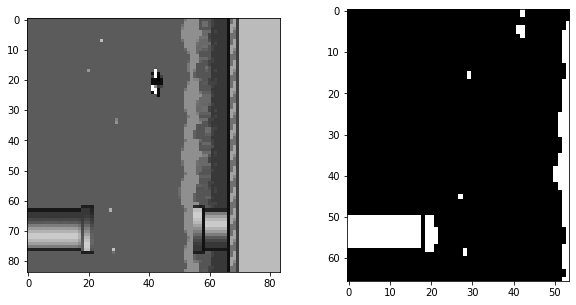

In [ ]:
image = game.get_image()
image = cv2.cvtColor(cv2.resize(image, (84, 84)), cv2.COLOR_BGR2GRAY)
ret, thresh1 = cv2.threshold(image, 127,255, cv2.THRESH_BINARY)
f, ax = plt.subplots(1, 2, figsize=(10, 5))
# plt.subplot(2, 1, 1),
ax[0].imshow(image, 'gray')
# plt.subplot(2, 1, 2)
ax[1].imshow(thresh1[18:,:-30], 'gray')
# plt.imshow(image)

In [ ]:
thresh1[18:,:-18].shape
[18:, :84]

(66, 66)

In [ ]:
thresh1.shape

(84, 84)

In [ ]:
model = DQN()
# model_target = DQN()

if args.use_pretrained:
    model = torch.load(
        sorted(glob(os.path.join('ckpt', args.tag, '*.pth')))[-1]
    )
else:
    os.makedirs(os.path.join('ckpt', args.tag), exist_ok = True)
    model.apply(init_weights)
model = model.cuda()
start = time.time()

episode = 0
iteration = 0

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=args.lr)

# instantiate game
game = Game(game=args.game)
high_total_reward = 0

In [ ]:
# initialize replay memory
memory = ReplayBuffer()

elapsed_time = 0
action = torch.zeros([model.number_of_actions], dtype=torch.float32)
total_reward = game.reward
terminal = game.game_over()

# image_data = game.get_torch_image().cuda()
image_data = image_preprocess(game.get_image()).cuda()
state = image_data.unsqueeze(0)

start = time.time()

In [ ]:
while iteration < args.iteration:
    output = model(state)[0]
    action = torch.zeros([model.number_of_actions], dtype=torch.float32)
    
    # epsilon greedy exploration
    # Pick action --> random or index of maximum q value
    epsilon = args.final_epsilon + ((args.iteration - iteration) * (args.initial_epsilon - args.final_epsilon) / args.iteration)
    coin = random.random()
    random_action = coin <= epsilon
    if random_action:
        action_index =  random.randint(0, 1)
    else:
        action_index =  output.argmax().item()

    # coin = random.random()
    # action_index = 0
    # if coin < epsilon:
    #     action_index =  random.randint(0, 1)
    # else:
    #     action_index =  output.argmax().item()

    action[action_index] = 1

    elapsed_time = time.time() - start

    # get next state and reward
    reward = game.act(action_index)
    terminal = game.game_over()
    
    # image_data_1 = game.get_torch_image().cuda()
    # state_1 = image_data_1.unsqueeze(0)
    image_data_1 = image_preprocess(game.get_image()).cuda()
    state_1 = image_data_1.unsqueeze(0)

    action = action.unsqueeze(0).cuda()
    reward = torch.from_numpy(np.array([reward], dtype=np.float32)).unsqueeze(0).cuda()
    done = torch.from_numpy(np.array([1.0 if terminal else 0.0], dtype=np.float32)).unsqueeze(0).cuda()

    # save transition to replay memory
    memory.put((state, action, reward, state_1, done))
    # if replay memory is full, remove the oldest transition
    if memory.isfull():
        memory.flush()

    #### minibatch Train
    # sample random minibatch
    # if (terminal) & (memory.size() > 2000):
    s_batch, a_batch, r_batch, s_prime_batch, done_batch = memory.sample()
    s_batch = s_batch.cuda()
    a_batch = a_batch.cuda()
    r_batch = r_batch.cuda()
    s_prime_batch = s_prime_batch.cuda()
    done_batch = done_batch.cuda()

    # get output for the next state
    q_out = model(s_batch)
    q_prime_out = model(s_prime_batch) # q target으로 하도록

    # 종료한 state는 더 이상 미래의 보상이 없으니까 (max Q 구할 필요 없음)
    y_hat = torch.cat(
                tuple(reward if done else reward + args.gamma * torch.max(prediction) for reward, done, prediction in zip(r_batch, done_batch, q_prime_out))
            )
    y_hat = y_hat.detach()
    q_value = torch.sum(q_out * a_batch, dim=1)
    
    # calculate with target network
    optimizer.zero_grad()
    loss = criterion(q_value, y_hat)

    loss.backward()
    optimizer.step()

    state = state_1
    iteration += 1
    total_reward += game.reward

    args.writer.add_scalar('Train/loss', loss, iteration)

    if terminal:
        args.writer.add_scalar('Episode/elapsed_time', elapsed_time, episode)
        args.writer.add_scalar('Episode/episode', episode, episode)
        args.writer.add_scalar('Episode/total_reward', total_reward, episode)
        
        game.reset_game()
        episode += 1
        start = time.time()
        print('Episode {} (Iteration {}): Agent passed {} pipes!, Time: {:.3f} epsilon: {:.4f}'.format(episode, iteration, total_reward, elapsed_time, epsilon))
        if total_reward > high_total_reward:
            print('Weight Saved!')
            high_total_reward = total_reward
            torch.save(model,
                        os.path.join('ckpt', args.tag, 'E{:07d}_S{:03d}.pth'.format(episode, int(total_reward)))
                        )
        total_reward = 0
        # image_data = game.get_torch_image().cuda()
        # state = image_data.unsqueeze(0)

print("Saving final model")
torch.save(model,
            os.path.join('ckpt', args.tag, 'E_{:07d}_S{:03d}.pth'.format(episode, int(high_total_reward)))
            )

Episode 1 (Iteration 37): Agent passed 0.0 pipes!, Time: 13.159 epsilon: 0.1000
Episode 2 (Iteration 74): Agent passed 0.0 pipes!, Time: 0.364 epsilon: 0.1000
Episode 3 (Iteration 121): Agent passed 1.0 pipes!, Time: 0.443 epsilon: 0.1000
Weight Saved!
Episode 4 (Iteration 157): Agent passed 0.0 pipes!, Time: 0.374 epsilon: 0.1000
Episode 5 (Iteration 194): Agent passed 0.0 pipes!, Time: 0.360 epsilon: 0.1000
Episode 6 (Iteration 231): Agent passed 0.0 pipes!, Time: 0.362 epsilon: 0.1000
Episode 7 (Iteration 268): Agent passed 0.0 pipes!, Time: 0.357 epsilon: 0.1000
Episode 8 (Iteration 306): Agent passed 0.0 pipes!, Time: 0.355 epsilon: 0.1000
Episode 9 (Iteration 382): Agent passed 1.0 pipes!, Time: 0.727 epsilon: 0.1000
Episode 10 (Iteration 455): Agent passed 1.0 pipes!, Time: 0.697 epsilon: 0.1000
Episode 11 (Iteration 492): Agent passed 0.0 pipes!, Time: 0.338 epsilon: 0.1000
Episode 12 (Iteration 529): Agent passed 0.0 pipes!, Time: 0.332 epsilon: 0.1000
Episode 13 (Iteration 57

### 기존 코드

In [ ]:
import os
import sys
import time
import random
import argparse
from glob import glob
from collections import deque

import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.tensorboard import SummaryWriter
import numpy as np

from game import Game
from utils import init_weights
from munch import Munch

def train(args):
    model = DQN()
    if args.use_pretrained:
        model = torch.load(
            sorted(glob(os.path.join('ckpt', args.tag, '*.pth')))[-1]
        )
    else:
        os.makedirs(os.path.join('ckpt', args.tag), exist_ok = True)
        model.apply(init_weights)
    model = model.cuda()
    start = time.time()

    episode = 0
    iteration = 0
    epsilon = args.epsilon

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=args.lr)

    # instantiate game
    game = Game(game=args.game)
    high_total_reward = 0

    # initialize replay memory
    """
    TO DO

    D =
    """

    elapsed_time = 0
    action = torch.zeros([model.number_of_actions], dtype=torch.float32)
    total_reward = game.reward
    terminal = game.game_over()

    image_data = game.get_torch_image().cuda()
    state = image_data.unsqueeze(0)

    start = time.time()

    while iteration < args.iteration:
        output = model(state)[0]
        action = torch.zeros([model.number_of_actions], dtype=torch.float32)

        # epsilon greedy exploration
        random_action = False
        """
        TO DO

        random_action =
        """

        # Pick action --> random or index of maximum q value
        action_index = 0
        """
        TO DO

        action_index =
        """

        action[action_index] = 1

        elapsed_time = time.time() - start

        # get next state and reward
        reward = game.act(action_index)
        terminal = game.game_over()
        image_data_1 = game.get_torch_image().cuda()

        state_1 = image_data_1.unsqueeze(0)
        action = action.unsqueeze(0).cuda()
        reward = torch.from_numpy(np.array([reward], dtype=np.float32)).unsqueeze(0).cuda()

        # save transition to replay memory
        """
        TO DO
        """

        # if replay memory is full, remove the oldest transition
        """
        TO DO
        """

        # sample random minibatch
        """
        TO DO
        """

        # get output for the next state
        output_1 = model(state_1)

        y = reward if terminal else reward + args.gamma * torch.max(output_1)

        # calculate with target network
        q_value = torch.sum(model(state) * action, dim=1)

        optimizer.zero_grad()
        y = y.detach()
        loss = criterion(q_value, y)

        loss.backward()
        optimizer.step()

        state = state_1
        iteration += 1
        total_reward += game.reward

        args.writer.add_scalar('Train/loss', loss, iteration)

        if terminal:
            args.writer.add_scalar('Episode/elapsed_time', elapsed_time, episode)
            args.writer.add_scalar('Episode/episode', episode, episode)
            args.writer.add_scalar('Episode/total_reward', total_reward, episode)
            total_reward = 0
            game.reset_game()
            episode += 1
            start = time.time()
            print('Episode {} (Iteration {}): Agent passed {} pipes!, Time: {:.3f}'.format(episode, iteration, total_reward, elapsed_time))
            if total_reward > high_total_reward:
                print('Weight Saved!')
                high_total_reward = total_reward
                torch.save(model,
                           os.path.join('ckpt', args.tag, 'E{:07d}_S{:03d}.pth'.format(episode, int(total_reward)))
                           )
    print("Saving final model")
    torch.save(model,
               os.path.join('ckpt', args.tag, 'E_{:07d}_S{:03d}.pth'.format(episode, int(high_total_reward)))
               )

In [ ]:
from munch import Munch
#parser = argparse.ArgumentParser(description='Deep Q Learning')
# Simple parser
args = {
    "game": "flappy",
    "gamma": 0.99,
    "epsilon": 0.02,
    "iteration": 1000000,
    "lr": 1e-4,
    "use_pretrained": False,
    "tag": "dqn",
    "writer": "writer"
}
args = Munch(args)

args.writer = SummaryWriter(os.path.join('ckpt', args.tag))

os.environ['CUDA_VISIBLE_DEVICES'] = "0"
print('GPU Enabled: {}'.format(torch.cuda.is_available()))

train(args)


In [ ]:
%load_ext tensorboard
%tensorboard --logdir=ckpt/dqn

### Test

GPU Enabled: True


In [ ]:
import os
import time
import argparse
from glob import glob

import torch

from game import Game
from utils import Recorder

# def test(args):
#     model = torch.load(
#         sorted(glob(os.path.join('ckpt', args.tag, '*.pth')))[-1],
#         map_location='cpu'
#     ).eval()
#     print('Loaded model: {}'.format(sorted(glob(os.path.join('ckpt', args.tag, '*.pth')))[-1]))
#     # initialize video writer
#     video_filename = 'output_{}.avi'.format(args.tag)

#     dict_screen_shape = {
#         "flappy":(288, 512),
#     }
#     out = Recorder(video_filename=video_filename, fps=30,
#                    width=dict_screen_shape[args.game][0],
#                    height=dict_screen_shape[args.game][1])
#     total_reward_list = []
#     time_list = []

#     rewards = {
#         "positive": 1, # when the plasyer pass the pipe
#         "tick": 0, # at every tick
#         "loss": 0, # when died
#     }
#     game = Game(seed=args.seed, game=args.game, rewards=rewards)
#     for trials in range(10):

#         elapsed_Time = 0
#         action = torch.zeros([model.number_of_actions], dtype=torch.float32)
#         terminal = game.game_over()
#         start = time.time()
#         total_reward = 0

#         image_data = game.get_torch_image()
#         state = image_data.unsqueeze(0)
#         while not terminal:
#             output = model(state)[0]
#             action = torch.zeros([model.number_of_actions], dtype=torch.float32)
#             action_index = torch.argmax(output)
#             total_reward += game.act(action_index)
#             terminal = game.game_over()
#             image_data_1 = game.get_torch_image()
#             state = image_data_1.unsqueeze(0)

#             out.write(game.get_image())

#         game.reset_game()
#         total_reward_list.append(total_reward)
#         time_list.append(time.time()-start)
#         print('Game Ended!')
#         print('Total reward: {} !'.format(total_reward))

#     # Add summary
#     out.write_score(sum(total_reward_list), sum(time_list))
#     out.save()
#     print('Cumulated Total Reward: {}'.format(sum(total_reward_list)))
#     print('Total Run Time: {:.3f}'.format(sum(time_list)))

# if __name__ == "__main__":
#     parser = argparse.ArgumentParser(description='Deep Q Learning')
#     parser.add_argument('--seed', default=42, type=int,
#                         help='Random seed')
#     parser.add_argument('--game', default='flappy', type=str,
#                         help='{flappy}')
#     parser.add_argument('--tag', default="dqn", type=str,
#                         help='name to save')
#     args = parser.parse_args()

#     test(args)

### 테스트

In [ ]:
import os
import time
import argparse
from glob import glob

import torch

from game import Game
from utils import Recorder


In [55]:
args = {
    "game": "flappy",
    "gamma": 0.99,
    "initial_epsilon": 0.1,
    "final_epsilon":1e-4,
    "iteration": 2000000,
    "lr": 1e-6,
    "use_pretrained": False,
    "tag": "dqn",
    "writer": "writer",
    "batch_size" : 32,
    "memory_size":50000,
    "update_interval":10,
    "seed":42
}
args = Munch(args)

args.writer = SummaryWriter(os.path.join('ckpt', args.tag))

os.environ['CUDA_VISIBLE_DEVICES'] = "0"
print('GPU Enabled: {}'.format(torch.cuda.is_available()))

GPU Enabled: True


In [56]:
model = torch.load(
    sorted(glob(os.path.join('ckpt', args.tag, '*.pth')))[-1],
    map_location='cpu'
).eval()
print('Loaded model: {}'.format(sorted(glob(os.path.join('ckpt', args.tag, '*.pth')))[-1]))

Loaded model: ckpt/dqn/E_0007812_S022.pth


In [57]:
video_filename = 'output_{}.avi'.format(args.tag)

dict_screen_shape = {
    "flappy":(288, 512),
}
out = Recorder(video_filename=video_filename, fps=30,
                width=dict_screen_shape[args.game][0],
                height=dict_screen_shape[args.game][1])
total_reward_list = []
time_list = []

rewards = {
    "positive": 1, # when the plasyer pass the pipe
    "tick": 0, # at every tick
    "loss": 0, # when died
}
game = Game(seed=args.seed, game=args.game, rewards=rewards)

In [58]:
for trials in range(10):

    elapsed_Time = 0
    action = torch.zeros([model.number_of_actions], dtype=torch.float32)
    terminal = game.game_over()
    start = time.time()
    total_reward = 0

    image_data = game.get_torch_image()
    state = image_data.unsqueeze(0)
    while not terminal:
        output = model(state)[0]
        action = torch.zeros([model.number_of_actions], dtype=torch.float32)
        action_index = torch.argmax(output)
        total_reward += game.act(action_index)
        terminal = game.game_over()
        image_data_1 = game.get_torch_image()
        state = image_data_1.unsqueeze(0)

        out.write(game.get_image())

    game.reset_game()
    total_reward_list.append(total_reward)
    time_list.append(time.time()-start)
    print('Game Ended!')
    print('Total reward: {} !'.format(total_reward))

# Add summary
out.write_score(sum(total_reward_list), sum(time_list))
out.save()
print('Cumulated Total Reward: {}'.format(sum(total_reward_list)))
print('Total Run Time: {:.3f}'.format(sum(time_list)))

Game Ended!
Total reward: 3.0 !
Game Ended!
Total reward: 11.0 !
Game Ended!
Total reward: 0.0 !
Game Ended!
Total reward: 20.0 !
Game Ended!
Total reward: 2.0 !
Game Ended!
Total reward: 5.0 !
Game Ended!
Total reward: 20.0 !
Game Ended!
Total reward: 1.0 !
Game Ended!
Total reward: 21.0 !
Game Ended!
Total reward: 17.0 !
Cumulated Total Reward: 100.0
Total Run Time: 30.427
